#### Notebook includes:

- Notebook purpose description
- Data loading
- Description and implementation of the function used to extract and organize seismic partial stack data
- Merging the partial stacks 
- QC of the new partial seismics sets of cubes

#### Notebook purpose


In this notebook it's shown how the raw reprocessed vintage data is extracted and reorganaized into one single dataset.



It also includess data difference explanations as well as the solution of getting all the partial seismic into one shape and thus making up a datafile ready for a well link. You can also observe what final data frame looks like and other prints to better follow the process. In the final section one can also observe a displayed seismic data from the raw file, and newly formed set of the data cubes. Given the images consistency, it was concluded that newly formed seismic datafile has no organization issues, and all the coordinates and amplitudes are consistent with the raw data.

In [2]:
import pandas as pd
import numpy as np
import os 
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from segysak.segy import segy_loader, well_known_byte_locs, segy_writer
from segysak.segy import segy_loader, segy_header_scan, segy_header_scrape
import segyio
style.use('seaborn')
from segysak import create3d_dataset
import xarray as xr 
import segyio
import numpy as np
import itertools

import re
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load Data

## New vintage data loading

### Seismic section extracting and keeping in xarray format for further operations

In [3]:
segyfile1 = '../data/ST10010ZC11_PZ_PSDM_KIRCH_FAR_T.MIG_FIN.POST_STACK.3D.JS-017536.segy'
segyfile2 = '../data/ST10010ZC11_PZ_PSDM_KIRCH_MID_T.MIG_FIN.POST_STACK.3D.JS-017536.segy'
segyfile3 = '../data/ST10010ZC11_PZ_PSDM_KIRCH_NEAR_MID_T.MIG_FIN.POST_STACK.3D.JS-017536.segy'
segyfile4 = '../data/ST10010ZC11_PZ_PSDM_KIRCH_NEAR_T.MIG_FIN.POST_STACK.3D.JS-017536.segy'

In [4]:
f = segyio.open(segyfile1, ignore_geometry=True)
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

print(f'Far: xl min {min(np.unique(xl))}, xl max {max(np.unique(xl))}')

f = segyio.open(segyfile2, ignore_geometry=True)
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

print(f'Mid: xl min {min(np.unique(xl))}, xl max {max(np.unique(xl))}')



f = segyio.open(segyfile3, ignore_geometry=True)
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

print(f'Near-mid: xl min {min(np.unique(xl))}, xl max {max(np.unique(xl))}')



f = segyio.open(segyfile4, ignore_geometry=True)
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

print(f'Near: xl min {min(np.unique(xl))}, xl max {max(np.unique(xl))}')


Far: xl min 1961, xl max 2680
Mid: xl min 1961, xl max 2680
Near-mid: xl min 1961, xl max 2680
Near: xl min 2000, xl max 2647


Now we know that near seismic is different in terms of the shape. Thus, we will need to mask the seismic data accordindgly.

#### Extraction and organization of seismic partial stack data

##### Far seismic cube

The code below extracts the inline and crosslines of the partial seismic and creates a grid out of the lines extracted. Afterwards the regular grid data is inserted into the empty seismic cube with the shape being consistent to the data shape in the grid. It esentially organizes the raw seismic data into the sorted seismic cube. The same is being done to all other partial stacks.

In [5]:
f = segyio.open(segyfile1, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
# traces = traces[:, 0:len(traces)+1]
ntraces, nt = traces.shape
t = f.samples

il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il) 
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# dims iline, xline, vert
dims = (nil, nxl, traces.shape[1])

new_seisnc_far = create3d_dataset(
    dims,
    first_iline=ilines[0],
    iline_step=dil,
    first_xline=xlines[0],
    xline_step=dxl,
    first_sample=4,
    sample_rate=dt,
    vert_domain="TWT",
)


# get the dims
dims = new_seisnc_far.dims
print(dims)
dkeys = ("iline", "xline", "twt")
dsize = [dims[key] for key in dkeys]
print("keys:", dkeys, "sizes:", dsize)


# assign the data to dataset by passing in a tuple of the dimension keys and the new data
new_seisnc_far["far_seis"] = (dkeys,d)

new_seisnc_far.to_dataframe()

Frozen({'iline': 401, 'xline': 720, 'twt': 850})
keys: ('iline', 'xline', 'twt') sizes: [401, 720, 850]


far_seis
iline xline twt           
9961  1961  4     0.000000
            8     0.000000
            12    0.000000
            16    0.000000
            20    0.000000
...                    ...
10361 2680  3384 -0.004612
            3388 -0.002769
            3392 -0.002660
            3396 -0.002106
            3400 -0.001582

[245412000 rows x 1 columns]

##### Mid seismic cube

In [6]:
f = segyio.open(segyfile2, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
# traces = traces[:, 0:len(traces)+1]
ntraces, nt = traces.shape
t = f.samples

il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces


# dims iline, xline, vert
dims = (nil, nxl, traces.shape[1])

new_seisnc_mid = create3d_dataset(
    dims,
    first_iline=ilines[0],
    iline_step=dil,
    first_xline=xlines[0],
    xline_step=dxl,
    first_sample=4,
    sample_rate=dt,
    vert_domain="TWT",
)

new_seisnc_mid


# get the dims
dims = new_seisnc_mid.dims
print(dims)
dkeys = ("iline", "xline", "twt")
dsize = [dims[key] for key in dkeys]
print("keys:", dkeys, "sizes:", dsize)


# assign the data to dataset by passing in a tuple of the dimension keys and the new data
new_seisnc_mid["mid_seis"] = (dkeys,d)

new_seisnc_mid.to_dataframe()


Frozen({'iline': 401, 'xline': 720, 'twt': 850})
keys: ('iline', 'xline', 'twt') sizes: [401, 720, 850]


mid_seis
iline xline twt           
9961  1961  4          0.0
            8          0.0
            12         0.0
            16         0.0
            20         0.0
...                    ...
10361 2680  3384       0.0
            3388       0.0
            3392       0.0
            3396       0.0
            3400       0.0

[245412000 rows x 1 columns]

##### Near mid seismic cube

In [7]:
f = segyio.open(segyfile3, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
# traces = traces[:, 0:len(traces)+1]
ntraces, nt = traces.shape
t = f.samples

il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces


# dims iline, xline, vert
dims = (nil, nxl, traces.shape[1])

new_seisnc_near_mid = create3d_dataset(
    dims,
    first_iline=ilines[0],
    iline_step=dil,
    first_xline=xlines[0],
    xline_step=dxl,
    first_sample=4,
    sample_rate=dt,
    vert_domain="TWT",
)

new_seisnc_near_mid


# get the dims
dims = new_seisnc_near_mid.dims
print(dims)
dkeys = ("iline", "xline", "twt")
dsize = [dims[key] for key in dkeys]
print("keys:", dkeys, "sizes:", dsize)


# assign the data to dataset by passing in a tuple of the dimension keys and the new data
new_seisnc_near_mid["near_mid_seis"] = (dkeys,d)

new_seisnc_near_mid.to_dataframe()


Frozen({'iline': 401, 'xline': 720, 'twt': 850})
keys: ('iline', 'xline', 'twt') sizes: [401, 720, 850]


near_mid_seis
iline xline twt                
9961  1961  4               0.0
            8               0.0
            12              0.0
            16              0.0
            20              0.0
...                         ...
10361 2680  3384            0.0
            3388            0.0
            3392            0.0
            3396            0.0
            3400            0.0

[245412000 rows x 1 columns]

##### Near seismic cube

In [8]:
f = segyio.open(segyfile4, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
# traces = traces[:, 0:len(traces)+1]
ntraces, nt = traces.shape
t = f.samples

il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces


# dims iline, xline, vert
dims = (nil, nxl, traces.shape[1])

new_seisnc_near = create3d_dataset(
    dims,
    first_iline=ilines[0],
    iline_step=dil,
    first_xline=xlines[0],
    xline_step=dxl,
    first_sample=4,
    sample_rate=dt,
    vert_domain="TWT",
)

new_seisnc_near


# get the dims
dims = new_seisnc_near.dims
print(dims)
dkeys = ("iline", "xline", "twt")
dsize = [dims[key] for key in dkeys]
print("keys:", dkeys, "sizes:", dsize)


# assign the data to dataset by passing in a tuple of the dimension keys and the new data
new_seisnc_near["near_seis"] = (dkeys,d)

new_seisnc_near.to_dataframe()


Frozen({'iline': 401, 'xline': 648, 'twt': 850})
keys: ('iline', 'xline', 'twt') sizes: [401, 648, 850]


near_seis
iline xline twt            
9961  2000  4           0.0
            8           0.0
            12          0.0
            16          0.0
            20          0.0
...                     ...
10361 2647  3384        0.0
            3388        0.0
            3392        0.0
            3396        0.0
            3400        0.0

[220870800 rows x 1 columns]

### Merging seismic cubes

We need to take into the accout that near seismic is of different shape. Given it's smaller that others, we first mask other seismic, and then combine all of them into the one xarray

In [9]:
# combining far, mid, near - mid seismic.

temp = xr.combine_by_coords([new_seisnc_far, new_seisnc_mid,new_seisnc_near_mid])

# filtering (masking) the combined seismic cubes

temp_sorted = temp.where((new_seisnc_far.xline >= 2000) & (new_seisnc_far.xline <= 2647), drop = True )

temp_sorted.to_dataframe()


far_seis      mid_seis  near_mid_seis
iline xline twt                                            
9961  2000  4    -8.247429e-08 -7.077543e-07  -7.196057e-07
            8     1.609937e-07 -2.517421e-07  -2.524722e-07
            12    5.376124e-07  3.353492e-07   3.506864e-07
            16    6.854757e-07  2.788975e-07   2.964707e-07
            20    7.940528e-07  7.433306e-08   8.907841e-08
...                        ...           ...            ...
10361 2647  3384  2.883038e-02  8.555806e-02   8.570492e-02
            3388  1.893795e-02  4.822142e-02   4.834799e-02
            3392  7.794928e-03  1.227780e-02   1.237139e-02
            3396 -2.024788e-03 -9.526573e-03  -9.447627e-03
            3400 -6.082382e-03 -1.609470e-02  -1.602004e-02

[220870800 rows x 3 columns]

#### Getting the final version of the seismic cubes set 

In [10]:
# joining far, mid and near mid seismic

temp = xr.combine_by_coords([new_seisnc_far, new_seisnc_mid,new_seisnc_near_mid])

# joning newly formed set of cubes with the near seismic. We drop attributes error if any, since corner point attribute is not the same

volve_seismic_new = xr.combine_by_coords([temp_sorted,new_seisnc_near],combine_attrs='drop')
volve_seismic_new.to_dataframe()

far_seis      mid_seis  near_mid_seis  near_seis
iline xline twt                                                       
9961  2000  4    -8.247429e-08 -7.077543e-07  -7.196057e-07        0.0
            8     1.609937e-07 -2.517421e-07  -2.524722e-07        0.0
            12    5.376124e-07  3.353492e-07   3.506864e-07        0.0
            16    6.854757e-07  2.788975e-07   2.964707e-07        0.0
            20    7.940528e-07  7.433306e-08   8.907841e-08        0.0
...                        ...           ...            ...        ...
10361 2647  3384  2.883038e-02  8.555806e-02   8.570492e-02        0.0
            3388  1.893795e-02  4.822142e-02   4.834799e-02        0.0
            3392  7.794928e-03  1.227780e-02   1.237139e-02        0.0
            3396 -2.024788e-03 -9.526573e-03  -9.447627e-03        0.0
            3400 -6.082382e-03 -1.609470e-02  -1.602004e-02        0.0

[220870800 rows x 4 columns]

In [14]:
volve_seismic_new.to_netcdf('../data/volve_seismic_new.nc')

### Check for consistency between raw data and newly formed set of seismic cubes

### Initial data

In [11]:
# Subsampling (can save file at the end only without subsampling)
jt = 1
jil = 1
jxl = 1

(2000.0, 2647.0, 3400.0, 4.0)

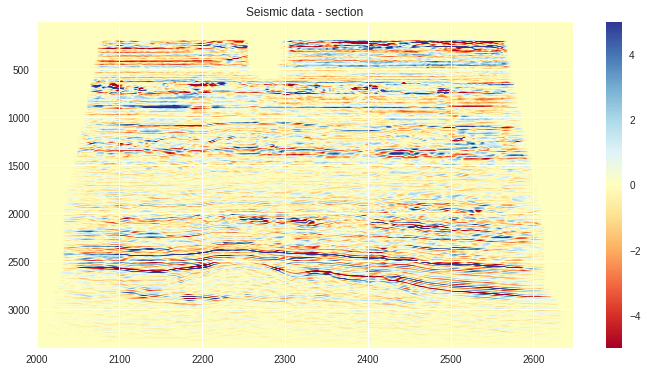

In [12]:
  # Subsample
d = d[::jil, ::jxl, ::jt]
ilines = ilines[::jil]
xlines = xlines[::jxl]
t = t[::jt]
nil, nxl, nt = len(ilines), len(xlines), len(t)

# # Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight')

### Data extracted from the newly formed seismic cube given the same subsample as above

(2000.0, 2647.0, 3400.0, 4.0)

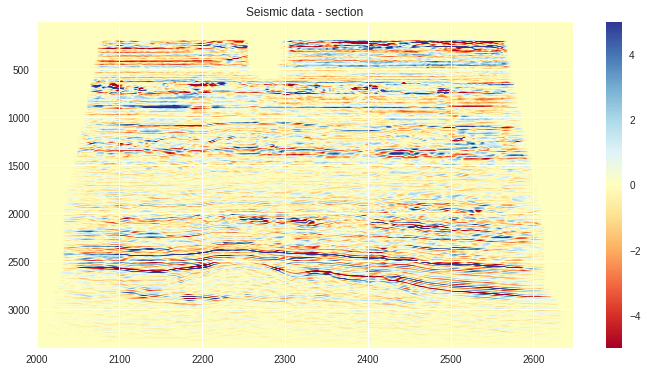

In [13]:
  # Subsample

  
d = volve_seismic_new.near_seis[::jil, ::jxl, ::jt]
ilines = volve_seismic_new.iline[::jil]
xlines = volve_seismic_new.xline[::jxl]
t = volve_seismic_new.twt[::jt]
nil, nxl, nt = len(ilines), len(xlines), len(t)

# # Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight')

##### We combined all the partial seismic into the cube. We performed some data manipulation to get the seismic cubes into the one shape. The data is ready to be linked with the well data.